In [1]:
import xarray as xr
import h3
import h3.unstable.vect
import h3.api.numpy_int
import numpy as np

/home/uko/Dev/ma_dashboard/.envs/ma_dashboard_env/lib/python3.10/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
ds = xr.tutorial.load_dataset("air_temperature").load()
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

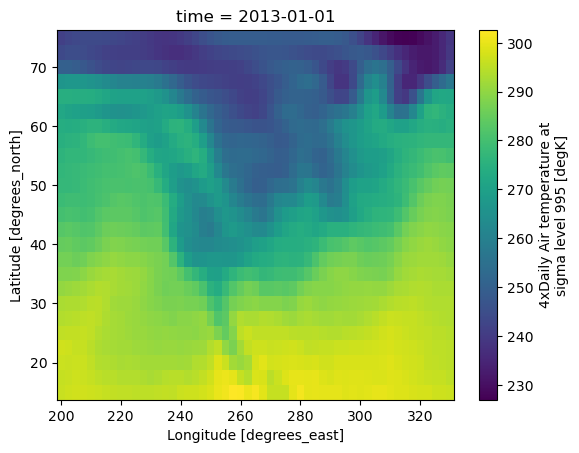

In [3]:
ds.air[0].plot()

In [43]:
resolution = 2

lon, lat = xr.broadcast(ds.lon, ds.lat)
%time index = h3.unstable.vect.geo_to_h3(lat.data.ravel(), lon.data.ravel(), resolution)
index.shape = lon.shape

len(np.unique(index)) / lon.size

CPU times: user 2.17 ms, sys: 0 ns, total: 2.17 ms
Wall time: 2.06 ms


0.6037735849056604

In [44]:
index.shape

(53, 25)

In [45]:
ds.lon.shape

(53,)

In [46]:
ds.coords["index"] = ("lat", "lon"), index.transpose()
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
    index    (lat, lon) uint64 11kB 585700498267439103 ... 587005068813795327
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

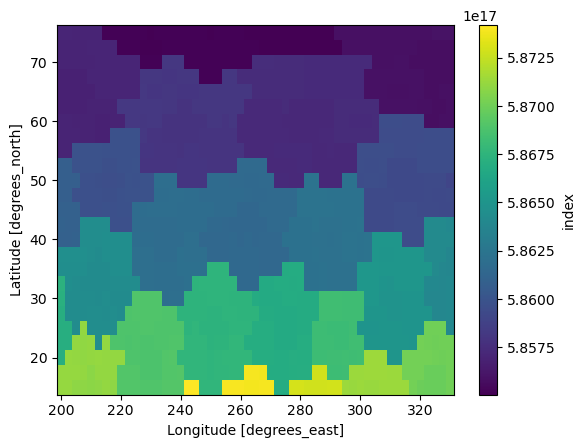

In [47]:
ds.index.plot()

In [48]:
lon_min, lon_max = ds.lon.min().values.item(), ds.lon.max().values.item()
lat_min, lat_max = ds.lat.min().values.item(), ds.lat.max().values.item()

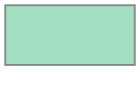

In [49]:
import shapely

bbox_coords = [
    (lon_min - 360, lat_min),
    (lon_min - 360, lat_max),
    (lon_max - 360, lat_max),
    (lon_max - 360, lat_min),
    (lon_min - 360, lat_min),
]
bbox = shapely.Polygon(bbox_coords)
bbox

In [50]:
bbox_coords

[(-160.0, 15.0), (-160.0, 75.0), (-30.0, 75.0), (-30.0, 15.0), (-160.0, 15.0)]

In [51]:
# h3 wants lat first
bbox_coords_lat_first = [(lat, lon) for lon, lat in bbox_coords]
bbox_indexes = np.array(
    list(h3.api.basic_int.polyfill_polygon(bbox_coords_lat_first, resolution))
)
bbox_indexes.shape

(760,)

In [52]:
ll_points = np.array([h3.api.numpy_int.h3_to_geo(i) for i in bbox_indexes])
ll_points_lon_first = ll_points[:, ::-1]
ll_points_lon_first

array([[-120.20551475,   17.1453254 ],
       [ -97.69355326,   20.04742637],
       [-155.01606182,   53.52382423],
       ...,
       [ -77.17256137,   20.20025657],
       [ -50.18897745,   43.42984583],
       [ -72.99754457,   38.20055213]])

In [53]:
coords = {"cell": bbox_indexes}

# remember to re-add the 360 degree offset
dsi = ds.interp(
    lon=xr.DataArray(ll_points_lon_first[:, 0] + 360, dims="cell", coords=coords),
    lat=xr.DataArray(ll_points_lon_first[:, 1], dims="cell", coords=coords),
)
dsi

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 2920, cell: 760)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
    index    (cell) float64 6kB 5.869e+17 5.868e+17 ... 5.859e+17 5.862e+17
    lon      (cell) float64 6kB 239.8 262.3 205.0 247.7 ... 282.8 309.8 287.0
    lat      (cell) float64 6kB 17.15 20.05 53.52 37.4 ... 56.07 20.2 43.43 38.2
  * cell     (cell) int64 6kB 586903363988226047 ... 586209022395285503
Data variables:
    air      (time, cell) float64 18MB 294.8 292.4 277.4 ... 299.1 272.1 277.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [54]:
dsi2 = dsi.drop_vars(["lon", "lat", "index"])
dsi2.cell.attrs = {"grid_name": "h3", "resolution": resolution}
dsi2.to_netcdf("data/h3_example.nc", format="NETCDF4")
dsi2

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 2920, cell: 760)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * cell     (cell) int64 6kB 586903363988226047 ... 586209022395285503
Data variables:
    air      (time, cell) float64 18MB 294.8 292.4 277.4 ... 299.1 272.1 277.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

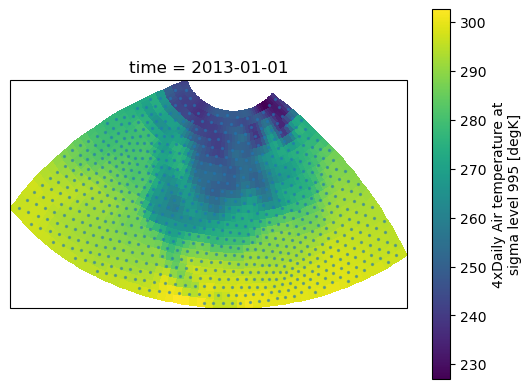

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

map_proj = ccrs.AzimuthalEquidistant(central_longitude=275, central_latitude=45)
ax = plt.subplot(projection=map_proj)
ds_air = ds.air[0]
p = ds_air.plot(transform = ccrs.PlateCarree(), ax = ax)  # the plot's projection

ax.scatter(ll_points_lon_first[:,0], ll_points_lon_first[:,1], edgecolor=None, s=2, alpha=0.5, transform=ccrs.PlateCarree())